# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [3]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
#creating validation set:
torch.manual_seed(5) #ensuring same split everytime
val_size = int(0.20 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

print("Train set size:", len(trainset))
print("Validation set size:", len(valset))
print("Test set size:", len(testset))

Train set size: 48000
Validation set size: 12000
Test set size: 10000


In [5]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
valloader_minibatch = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2,pin_memory=True)
for i, data in enumerate(trainloader_minibatch):
    print(data[0].shape)
    break

trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2,pin_memory=True)
valloader_stochastic = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=2,pin_memory=True)
for i, data in enumerate(trainloader_stochastic):
    print(data[0].shape)
    break

testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

torch.Size([32, 1, 28, 28])
torch.Size([1, 1, 28, 28])


### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP,self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        output = self.fc3(x)
        return output
    
model = SimpleMLP()
print(model)

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [7]:
#Parameter Values
learning_rate = 0.0001
momentum = 0.9
l2_reg = 0.001
#Optimizers
optimizers={
    'sgd': torch.optim.SGD,
    'momentum_sgd': torch.optim.SGD,
    'l2_sgd': torch.optim.SGD,
    'rmsprop': torch.optim.RMSprop,
    'adam': torch.optim.Adam
}

### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [8]:
epochs = 10
learning_rate = 0.001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
final_train_accuracy = []
final_test_accuracy = []
final_train_f1 = []
final_test_f1 = []

for optimizer_name, optimizer_fn in optimizers.items():
    print("Training with optimizer: {}".format(optimizer_name))
    model = SimpleMLP()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'sgd':
        optimizer = optimizer_fn(model.parameters(), lr = learning_rate)
    elif optimizer_name == 'momentum_sgd':
        optimizer = optimizer_fn(model.parameters(), lr = learning_rate, momentum=momentum)
    elif optimizer_name == 'l2_sgd':
        optimizer = optimizer_fn(model.parameters(), lr = learning_rate, weight_decay=l2_reg)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizer_fn(model.parameters(), lr = learning_rate)
    elif optimizer_name == 'adam':
        optimizer = optimizer_fn(model.parameters(), lr = learning_rate)

    train_loss = []
    validation_loss = []
    train_accuracy = []
    train_f1 = []
    model.train()
    for epoch in range(epochs):
        tra_loss = 0.0
        for idx, (data,label) in enumerate(trainloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item()
        #Calculating loss on Train Set
        train_loss.append(tra_loss/len(trainloader_minibatch))
        train_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
        train_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss/len(trainloader_minibatch)))
        model.eval()
        val_loss = 0.0
        for idx, (data,label) in enumerate(valloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()
        validation_loss.append(val_loss/len(valloader_minibatch))
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss/len(valloader_minibatch)))

    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    final_train_accuracy.append(train_accuracy)
    final_train_f1.append(train_f1)
    print("Training complete for optimizer: {}".format(optimizer_name))
    #get loss on test set
    model.eval()
    test_loss = 0.0
    for idx, (data,label) in enumerate(testloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output,label)
        test_loss += loss.item()
    final_test_loss.append(test_loss/len(testloader))
    final_test_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
    final_test_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
    print("Final test loss: {}".format(test_loss/len(testloader)))

Training with optimizer: sgd
Epoch: 1, Training Loss: 2.2866819310188293
Epoch: 1, Validation Loss: 2.2595104541778563
Epoch: 2, Training Loss: 2.2190615865389507
Epoch: 2, Validation Loss: 2.166452107747396
Epoch: 3, Training Loss: 2.0713036394913993
Epoch: 3, Validation Loss: 1.952468736966451
Epoch: 4, Training Loss: 1.7561219778855641
Epoch: 4, Validation Loss: 1.5397130330403646
Epoch: 5, Training Loss: 1.3006197888851165
Epoch: 5, Validation Loss: 1.0951957434018453
Epoch: 6, Training Loss: 0.9391058738231659
Epoch: 6, Validation Loss: 0.8239241156578064
Epoch: 7, Training Loss: 0.7369684868454933
Epoch: 7, Validation Loss: 0.6799069780508677
Epoch: 8, Training Loss: 0.6242661979794503
Epoch: 8, Validation Loss: 0.5944771207968393
Epoch: 9, Training Loss: 0.554481311182181
Epoch: 9, Validation Loss: 0.5393029261827469
Epoch: 10, Training Loss: 0.5071691318750381
Epoch: 10, Validation Loss: 0.5002130763133367
Training complete for optimizer: sgd
Final test loss: 0.4727847185045385

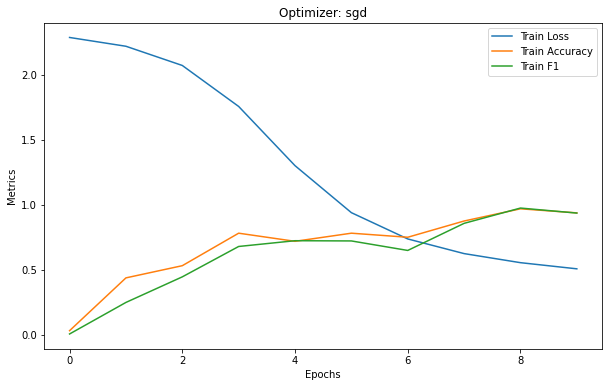

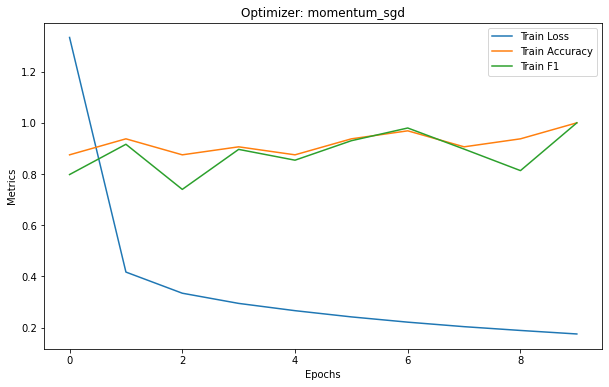

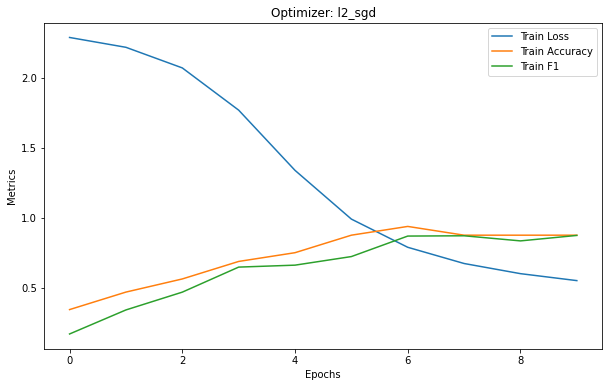

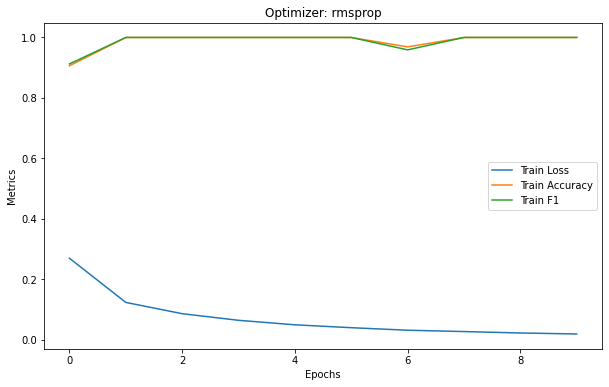

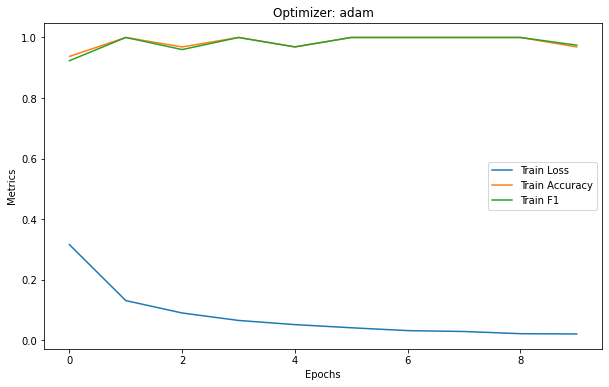

<Figure size 720x432 with 0 Axes>

In [9]:
"""
Plotting Train Losses, Accuracy and F1 Score
"""
plt.figure(figsize=(10, 6))
for i in range(len(optimizers)):
    plt.plot(final_train_loss[i], label='Train Loss')
    plt.plot(final_train_accuracy[i], label='Train Accuracy')
    plt.plot(final_train_f1[i], label='Train F1')
    plt.title("Optimizer: {}".format(list(optimizers.keys())[i]))
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 6))

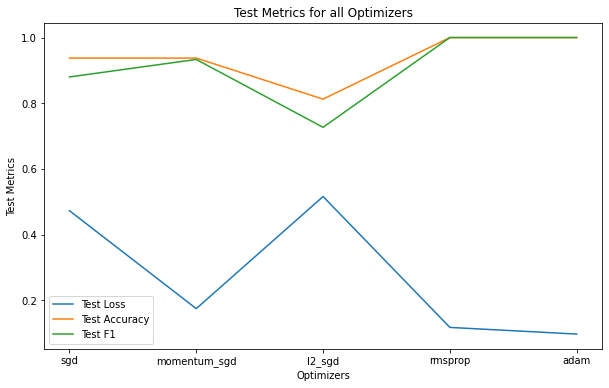

In [10]:
"""
Plotting Test Losses, Accuracy and F1 Score
"""
plt.figure(figsize=(10, 6))

optimizer_names = list(optimizers.keys())

plt.plot(optimizer_names, final_test_loss)
plt.plot(optimizer_names, final_test_accuracy)
plt.plot(optimizer_names, final_test_f1)
plt.title("Test Metrics for all Optimizers")
plt.xlabel("Optimizers")
plt.ylabel("Test Metrics")
plt.legend(['Test Loss', 'Test Accuracy', 'Test F1'])
plt.show()



In [11]:
import pandas as pd

train_metrics = pd.DataFrame({
    'Optimizer': list(optimizers.keys()),
    'Train Loss': [final_train_loss[i][-1] for i in range(len(optimizers))],
    'Train Accuracy': [final_train_accuracy[i][-1] for i in range(len(optimizers))],
    'Train F1': [final_train_f1[i][-1] for i in range(len(optimizers))]
})
print(train_metrics)

      Optimizer  Train Loss  Train Accuracy  Train F1
0           sgd    0.507169         0.93750  0.935931
1  momentum_sgd    0.175135         1.00000  1.000000
2        l2_sgd    0.550648         0.87500  0.873260
3       rmsprop    0.018827         1.00000  1.000000
4          adam    0.021169         0.96875  0.974603


In [12]:
test_metrics = pd.DataFrame({
    'Optimizer': list(optimizers.keys()),
    'Test Loss': final_test_loss,
    'Test Accuracy': final_test_accuracy,
    'Test F1': final_test_f1
})
print(test_metrics)

      Optimizer  Test Loss  Test Accuracy   Test F1
0           sgd   0.472785         0.9375  0.880000
1  momentum_sgd   0.174495         0.9375  0.933333
2        l2_sgd   0.515839         0.8125  0.726667
3       rmsprop   0.117279         1.0000  1.000000
4          adam   0.097003         1.0000  1.000000


## Analysis:

We observe that: 
1. `SGD with momentum` and `RMSprop`  give the highest train accuracy and scores.
2. `SGD with L2 regularization` is the only model whose train accuracy does not cross $90%$.
3. `RMSprop` and `Adam` give the best test accuracy and scores.
4. However, similar to the training analysis, `SGD with L2 regularization` does not cross $90%$ test accuracy compared to the other models.


### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

In [13]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [14]:
epochs = 10
learning_rate = 0.001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
final_train_accuracy = []
final_test_accuracy = []
final_train_f1 = []
final_test_f1 = []

model = SimpleMLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler1 = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1)

for scheduler in [scheduler1, scheduler2]:
    print("Training with LR Scheduler: {}".format(scheduler))
    train_loss = []
    validation_loss = []
    train_accuracy = []
    train_f1 = []
    model.train()
    for epoch in range(epochs):
        tra_loss = 0.0
        for idx, (data,label) in enumerate(trainloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item()
        #Calculating loss on Train Set
        train_loss.append(tra_loss/len(trainloader_minibatch))
        train_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
        train_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss/len(trainloader_minibatch)))
        scheduler.step()
        model.eval()
        val_loss = 0.0
        for idx, (data,label) in enumerate(valloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()
        validation_loss.append(val_loss/len(valloader_minibatch))
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss/len(valloader_minibatch)))

    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    final_train_accuracy.append(train_accuracy)
    final_train_f1.append(train_f1)
    print("Training complete for scheduler: {}".format(scheduler))
    #get loss on test set
    model.eval()
    test_loss = 0.0
    for idx, (data,label) in enumerate(testloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output,label)
        test_loss += loss.item()
    final_test_loss.append(test_loss/len(testloader))
    final_test_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
    final_test_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
    print("Final test loss: {}".format(test_loss/len(testloader)))


Training with LR Scheduler: <torch.optim.lr_scheduler.MultiplicativeLR object at 0x7f13b0154f40>
Epoch: 1, Training Loss: 0.3166200335510075
Epoch: 1, Validation Loss: 0.17787551655868689
Epoch: 2, Training Loss: 0.1292950569068392
Epoch: 2, Validation Loss: 0.1530998522825539
Epoch: 3, Training Loss: 0.0886679340764725
Epoch: 3, Validation Loss: 0.11262830404937267
Epoch: 4, Training Loss: 0.06509284984778302
Epoch: 4, Validation Loss: 0.1111980310746779
Epoch: 5, Training Loss: 0.0483661321104737
Epoch: 5, Validation Loss: 0.10078213246554757
Epoch: 6, Training Loss: 0.03635512941673126
Epoch: 6, Validation Loss: 0.09896031474058206
Epoch: 7, Training Loss: 0.02726657656461854
Epoch: 7, Validation Loss: 0.09396974509318048
Epoch: 8, Training Loss: 0.020906039149587743
Epoch: 8, Validation Loss: 0.09489696055767126
Epoch: 9, Training Loss: 0.01544406152825104
Epoch: 9, Validation Loss: 0.09675661632218786
Epoch: 10, Training Loss: 0.010635914379550134
Epoch: 10, Validation Loss: 0.101

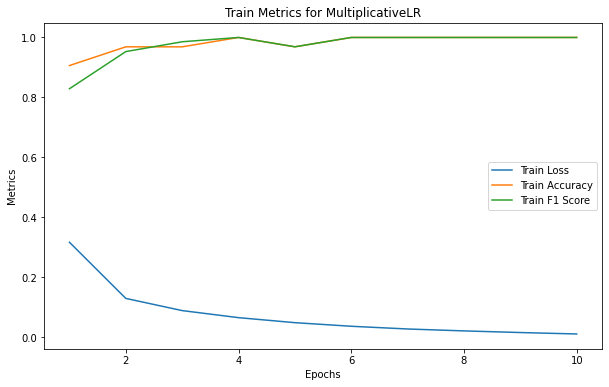

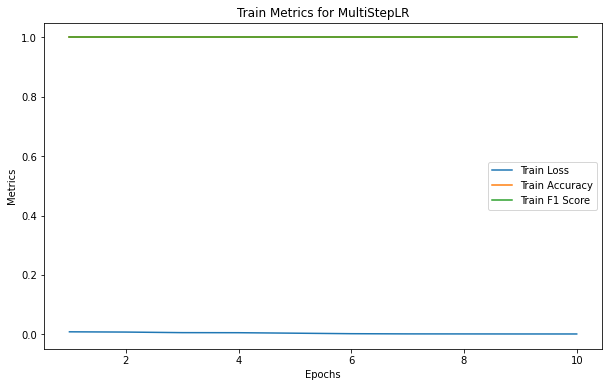

In [15]:
import matplotlib.pyplot as plt

scheduler_names = ['MultiplicativeLR', 'MultiStepLR']
schedulers = [scheduler1, scheduler2]

for i, scheduler in enumerate(schedulers):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Train Loss')
    plt.plot(range(1, epochs+1), final_train_accuracy[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), final_train_f1[i], label='Train F1 Score')
    plt.title(f'Train Metrics for {scheduler_names[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

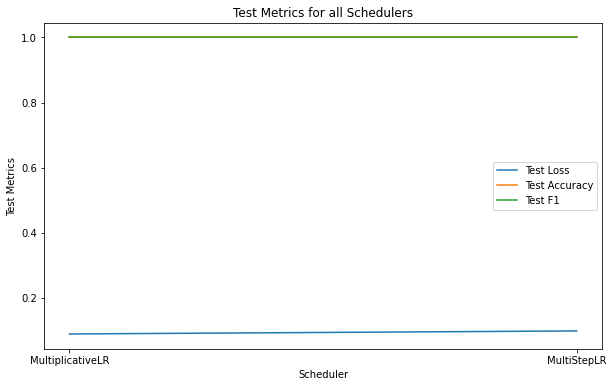

In [16]:
"""
Plotting Test Losses
"""
plt.figure(figsize=(10, 6))

scheduler_names = ['MultiplicativeLR', 'MultiStepLR']

plt.plot(scheduler_names, final_test_loss)
plt.plot(scheduler_names, final_test_accuracy)
plt.plot(scheduler_names, final_test_f1)
plt.title("Test Metrics for all Schedulers")
plt.xlabel("Scheduler")
plt.ylabel("Test Metrics")
plt.legend(['Test Loss', 'Test Accuracy', 'Test F1'])
plt.show()



In [17]:
import pandas as pd

scheduler_names = ['MultiplicativeLR', 'MultiStepLR']
final_train_loss = [train_loss[-1] for train_loss in final_train_loss]
final_train_accuracy = [train_accuracy[-1] for train_accuracy in final_train_accuracy]
final_train_f1 = [train_f1[-1] for train_f1 in final_train_f1]

data = {
    'Scheduler': scheduler_names,
    'Train Loss': final_train_loss,
    'Train Accuracy': final_train_accuracy,
    'Train F1 Score': final_train_f1
}

df = pd.DataFrame(data)
print(df)


          Scheduler  Train Loss  Train Accuracy  Train F1 Score
0  MultiplicativeLR    0.010636             1.0             1.0
1       MultiStepLR    0.000783             1.0             1.0


In [18]:
import pandas as pd

scheduler_names = ['MultiplicativeLR', 'MultiStepLR']

# Create a dictionary of the test metrics
test_metrics = {
    'Scheduler': scheduler_names,
    'Test Loss': final_test_loss,
    'Test Accuracy': final_test_accuracy,
    'Test F1 Score': final_test_f1
}

# Create a Pandas DataFrame from the dictionary
test_metrics_df = pd.DataFrame(test_metrics)

# Set the Scheduler column as the index
test_metrics_df.set_index('Scheduler', inplace=True)

# Display the DataFrame as a table
print(test_metrics_df)


                  Test Loss  Test Accuracy  Test F1 Score
Scheduler                                                
MultiplicativeLR   0.088559            1.0            1.0
MultiStepLR        0.097896            1.0            1.0


## Analysis:
We surprisingly observe that both the `MultiplicativeLR` and `MultiStepLR` scheduler give $1.0$ (perfect score) train and test results. The only difference we can observe is that the Test loss for `MultiplicativeLR` is lesser (much better) compared to `MultiStepLR`.

### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [19]:
# code here
class SimpleMLP_BN(nn.Module):
    def __init__(self):
        super(SimpleMLP_BN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        output = self.fc3(x)
        return output
    
class SimpleMLP_Dropout(nn.Module):
    def __init__(self):
        super(SimpleMLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        output = self.fc3(x)
        return output

class SimpleMLP_BN_Dropout(nn.Module):
    def __init__(self):
        super(SimpleMLP_BN_Dropout, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.dropout(self.bn1(self.fc1(x))))
        x = self.relu(self.dropout(self.bn2(self.fc2(x))))
        output = self.fc3(x)
        return output

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

In [20]:
learning_rate = 0.001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
final_train_accuracy = []
final_test_accuracy = []
final_train_f1 = []
final_test_f1 = []

# Model 1: SimpleMLP with Batch Normalization
model1 = SimpleMLP_BN()
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

# Model 2: SimpleMLP with Dropout
model2 = SimpleMLP_Dropout()
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)


# Model 3: SimpleMLP with Batch Normalization and Dropout
model3 = SimpleMLP_BN_Dropout()
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

In [21]:
epochs = 10
for model, optimizer in [(model1, optimizer1), (model2, optimizer2), (model3, optimizer3)]:
    print("Training Model: {}".format(model.__class__.__name__))
    train_loss = []
    validation_loss = []
    train_accuracy = []
    train_f1 = []
    model.train()
    for epoch in range(epochs):
        tra_loss = 0.0
        for idx, (data,label) in enumerate(trainloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item()
        # Calculating loss on Train Set
        train_loss.append(tra_loss/len(trainloader_minibatch))
        train_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
        train_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss/len(trainloader_minibatch)))
        
        model.eval()
        val_loss = 0.0
        for idx, (data,label) in enumerate(valloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()
        validation_loss.append(val_loss/len(valloader_minibatch))
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss/len(valloader_minibatch)))

    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    final_train_accuracy.append(train_accuracy)
    final_train_f1.append(train_f1)
    print("Training complete for model: {}".format(model.__class__.__name__))
    
    # Get loss on test set
    model.eval()
    test_loss = 0.0
    for idx, (data,label) in enumerate(testloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output,label)
        test_loss += loss.item()
    final_test_loss.append(test_loss/len(testloader))
    final_test_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
    final_test_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
    print("Final test loss: {}".format(test_loss/len(testloader)))

Training Model: SimpleMLP_BN
Epoch: 1, Training Loss: 0.2718743102947871
Epoch: 1, Validation Loss: 0.1303872165903449
Epoch: 2, Training Loss: 0.10210059621410134
Epoch: 2, Validation Loss: 0.11207029622296492
Epoch: 3, Training Loss: 0.0675763082394454
Epoch: 3, Validation Loss: 0.09386163392259429
Epoch: 4, Training Loss: 0.050999223490885925
Epoch: 4, Validation Loss: 0.10454389861101905
Epoch: 5, Training Loss: 0.04236371352675875
Epoch: 5, Validation Loss: 0.08894403124666618
Epoch: 6, Training Loss: 0.03480448588802149
Epoch: 6, Validation Loss: 0.1077512961254106
Epoch: 7, Training Loss: 0.031081543179340466
Epoch: 7, Validation Loss: 0.09327972394105745
Epoch: 8, Training Loss: 0.02683519218690344
Epoch: 8, Validation Loss: 0.11628470955246788
Epoch: 9, Training Loss: 0.023846857801828568
Epoch: 9, Validation Loss: 0.10914958658246905
Epoch: 10, Training Loss: 0.021849161889071184
Epoch: 10, Validation Loss: 0.10907931652995952
Training complete for model: SimpleMLP_BN
Final t

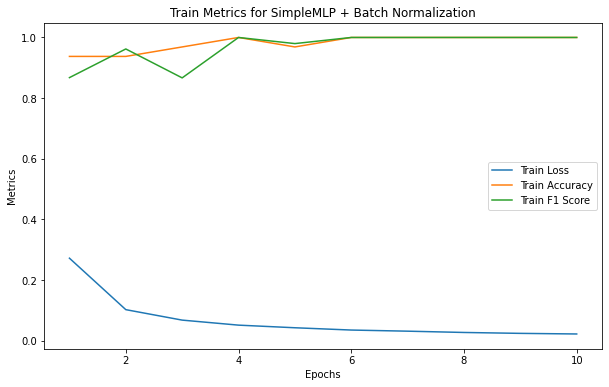

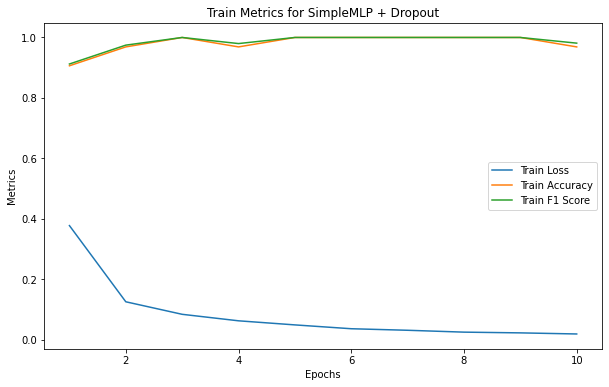

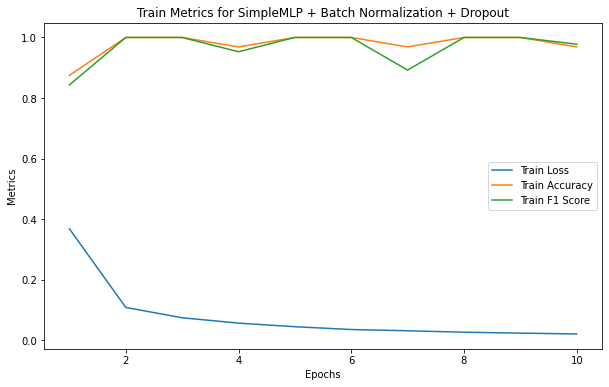

In [22]:
import matplotlib.pyplot as plt

model_names = ['SimpleMLP + Batch Normalization', 'SimpleMLP + Dropout','SimpleMLP + Batch Normalization + Dropout']

for i in range(len(model_names)):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Train Loss')
    plt.plot(range(1, epochs+1), final_train_accuracy[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), final_train_f1[i], label='Train F1 Score')
    plt.title(f'Train Metrics for {model_names[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

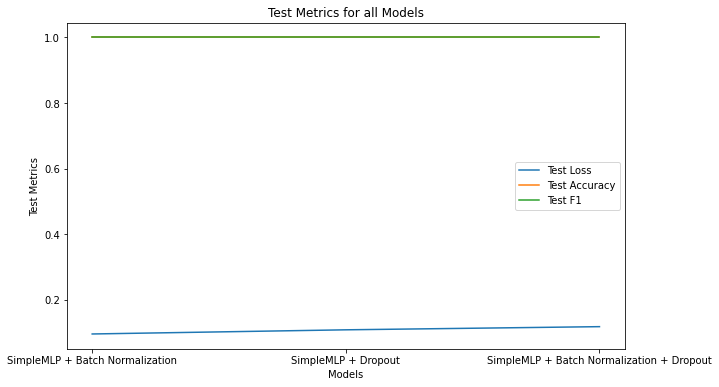

In [23]:
"""
Plotting Test Losses
"""
plt.figure(figsize=(10, 6))

model_names = ['SimpleMLP + Batch Normalization', 'SimpleMLP + Dropout','SimpleMLP + Batch Normalization + Dropout']

plt.plot(model_names, final_test_loss)
plt.plot(model_names, final_test_accuracy)
plt.plot(model_names, final_test_f1)
plt.title("Test Metrics for all Models")
plt.xlabel("Models")
plt.ylabel("Test Metrics")
plt.legend(['Test Loss', 'Test Accuracy', 'Test F1'])
plt.show()


In [24]:
model_names = ['SimpleMLP + Batch Normalization', 'SimpleMLP + Dropout','SimpleMLP + Batch Normalization + Dropout']
final_train_loss = [train_loss[-1] for train_loss in final_train_loss]
final_train_accuracy = [train_accuracy[-1] for train_accuracy in final_train_accuracy]
final_train_f1 = [train_f1[-1] for train_f1 in final_train_f1]

data = {
    'Model Name': model_names,
    'Train Loss': final_train_loss,
    'Train Accuracy': final_train_accuracy,
    'Train F1 Score': final_train_f1
}

df = pd.DataFrame(data)
print(df)


                                  Model Name  Train Loss  Train Accuracy  \
0            SimpleMLP + Batch Normalization    0.021849         1.00000   
1                        SimpleMLP + Dropout    0.018352         0.96875   
2  SimpleMLP + Batch Normalization + Dropout    0.020632         0.96875   

   Train F1 Score  
0        1.000000  
1        0.981197  
2        0.977778  


In [25]:
import pandas as pd

model_names = ['SimpleMLP + Batch Normalization', 'SimpleMLP + Dropout','SimpleMLP + Batch Normalization + Dropout']

test_metrics = {
    'Model Names': model_names,
    'Test Loss': final_test_loss,
    'Test Accuracy': final_test_accuracy,
    'Test F1 Score': final_test_f1
}

test_metrics_df = pd.DataFrame(test_metrics)
test_metrics_df.set_index('Model Names', inplace=True)
print(test_metrics_df)


                                           Test Loss  Test Accuracy  \
Model Names                                                           
SimpleMLP + Batch Normalization             0.095376            1.0   
SimpleMLP + Dropout                         0.108059            1.0   
SimpleMLP + Batch Normalization + Dropout   0.117693            1.0   

                                           Test F1 Score  
Model Names                                               
SimpleMLP + Batch Normalization                      1.0  
SimpleMLP + Dropout                                  1.0  
SimpleMLP + Batch Normalization + Dropout            1.0  


## Analysis:
`SimpleMLP+Batch Normalization` gives the best Train Accuracy compared to the other two model architectures. The other two models have a lower train loss possibly signifying that they are overfitting to some extent. However, regardless of that, all the three models give a perfect score `1.0` for the Test Accuracies. In fact, `SimpleMLP+Batch Normalization` gives a much lower test loss compared to the other models. This indicates it is overall learning better. 

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

In [26]:
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=2,pin_memory=True)
valloader_stochastic = torch.utils.data.DataLoader(valset, batch_size=2, shuffle=False, num_workers=2,pin_memory=True)
for i, data in enumerate(trainloader_stochastic):
    print(data[0].shape)
    break

torch.Size([2, 1, 28, 28])


In [27]:
learning_rate = 0.001
final_train_loss = []
final_validation_loss = []
final_test_loss = []
final_train_accuracy = []
final_test_accuracy = []
final_train_f1 = []
final_test_f1 = []

model_best = SimpleMLP_BN()
model_best = model_best.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_best = optim.Adam(model_best.parameters(), lr=learning_rate)


In [28]:
epochs = 10
for model, optimizer in [(model_best, optimizer_best)]:
    print("Training Model: {}".format(model.__class__.__name__))
    train_loss = []
    validation_loss = []
    train_accuracy = []
    train_f1 = []
    model.train()
    for epoch in range(epochs):
        tra_loss = 0.0
        for idx, (data,label) in enumerate(trainloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item()
        # Calculating loss on Train Set
        train_loss.append(tra_loss/len(trainloader_minibatch))
        train_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
        train_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss/len(trainloader_minibatch)))
        
        model.eval()
        val_loss = 0.0
        for idx, (data,label) in enumerate(valloader_minibatch):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()
        validation_loss.append(val_loss/len(valloader_minibatch))
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss/len(valloader_minibatch)))

    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    final_train_accuracy.append(train_accuracy)
    final_train_f1.append(train_f1)
    print("Training complete for model: {}".format(model.__class__.__name__))
    
    # Get loss on test set
    model.eval()
    test_loss = 0.0
    for idx, (data,label) in enumerate(testloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output,label)
        test_loss += loss.item()
    final_test_loss.append(test_loss/len(testloader))
    final_test_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
    final_test_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
    print("Final test loss: {}".format(test_loss/len(testloader)))

Training Model: SimpleMLP_BN
Epoch: 1, Training Loss: 0.27024411255742115
Epoch: 1, Validation Loss: 0.12265287370731433
Epoch: 2, Training Loss: 0.1006156894688805
Epoch: 2, Validation Loss: 0.10617992014189562
Epoch: 3, Training Loss: 0.06906730845038934
Epoch: 3, Validation Loss: 0.09083126085515444
Epoch: 4, Training Loss: 0.05149014188240593
Epoch: 4, Validation Loss: 0.08799738815884726
Epoch: 5, Training Loss: 0.042841724776662884
Epoch: 5, Validation Loss: 0.10338115376338829
Epoch: 6, Training Loss: 0.03736666607564985
Epoch: 6, Validation Loss: 0.10983504427247681
Epoch: 7, Training Loss: 0.029892195895517944
Epoch: 7, Validation Loss: 0.1008264087101367
Epoch: 8, Training Loss: 0.026823326767480466
Epoch: 8, Validation Loss: 0.10686504880491217
Epoch: 9, Training Loss: 0.023971719349138464
Epoch: 9, Validation Loss: 0.1234953274343643
Epoch: 10, Training Loss: 0.02220629855859746
Epoch: 10, Validation Loss: 0.11703244553578891
Training complete for model: SimpleMLP_BN
Final 

In [29]:
model_best = SimpleMLP_BN()
model_best = model_best.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_best = optim.Adam(model_best.parameters(), lr=learning_rate)

In [30]:
epochs = 10
for model, optimizer in [(model_best, optimizer_best)]:
    print("Training Model: {}".format(model.__class__.__name__))
    train_loss = []
    validation_loss = []
    train_accuracy = []
    train_f1 = []
    model.train()
    for epoch in range(epochs):
        tra_loss = 0.0
        for idx, (data,label) in enumerate(trainloader_stochastic):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            tra_loss += loss.item()
        # Calculating loss on Train Set
        train_loss.append(tra_loss/len(trainloader_stochastic))
        train_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
        train_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
        print("Epoch: {}, Training Loss: {}".format(epoch+1, tra_loss/len(trainloader_stochastic)))
        
        model.eval()
        val_loss = 0.0
        for idx, (data,label) in enumerate(valloader_stochastic):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()
        validation_loss.append(val_loss/len(valloader_stochastic))
        print("Epoch: {}, Validation Loss: {}".format(epoch+1, val_loss/len(valloader_stochastic)))

    final_train_loss.append(train_loss)
    final_validation_loss.append(validation_loss)
    final_train_accuracy.append(train_accuracy)
    final_train_f1.append(train_f1)
    print("Training complete for model: {}".format(model.__class__.__name__))
    
    # Get loss on test set
    model.eval()
    test_loss = 0.0
    for idx, (data,label) in enumerate(testloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output,label)
        test_loss += loss.item()
    final_test_loss.append(test_loss/len(testloader))
    final_test_accuracy.append(accuracy_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy()))
    final_test_f1.append(f1_score(label.cpu().numpy(), torch.argmax(output, dim=1).cpu().numpy(), average='macro'))
    print("Final test loss: {}".format(test_loss/len(testloader)))

Training Model: SimpleMLP_BN
Epoch: 1, Training Loss: 1.6282191033127407
Epoch: 1, Validation Loss: 1.1054820966056238
Epoch: 2, Training Loss: 0.24952089349787335
Epoch: 2, Validation Loss: 0.1514463946178033
Epoch: 3, Training Loss: 0.1170737478821288
Epoch: 3, Validation Loss: 0.14035069713264184
Epoch: 4, Training Loss: 0.08466015868918916
Epoch: 4, Validation Loss: 0.12976526513349235
Epoch: 5, Training Loss: 0.06880058811400211
Epoch: 5, Validation Loss: 0.11347177765182052
Epoch: 6, Training Loss: 0.05492197412627496
Epoch: 6, Validation Loss: 0.10806024687516604
Epoch: 7, Training Loss: 0.046543400865108844
Epoch: 7, Validation Loss: 0.12061124958985436
Epoch: 8, Training Loss: 0.04071573870814117
Epoch: 8, Validation Loss: 0.11169327109399908
Epoch: 9, Training Loss: 0.032972282796525226
Epoch: 9, Validation Loss: 0.11880190100934566
Epoch: 10, Training Loss: 0.03106361789838269
Epoch: 10, Validation Loss: 0.128715982179812
Training complete for model: SimpleMLP_BN
Final test 

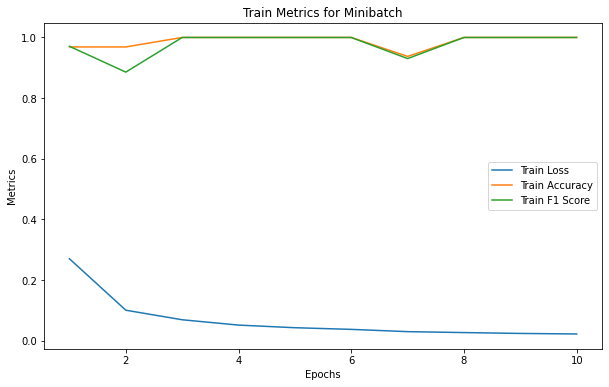

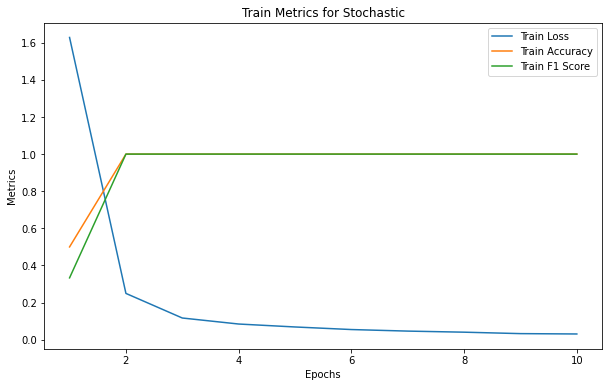

In [31]:
import matplotlib.pyplot as plt

data_names = ['Minibatch','Stochastic']

for i in range(len(data_names)):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), final_train_loss[i], label='Train Loss')
    plt.plot(range(1, epochs+1), final_train_accuracy[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), final_train_f1[i], label='Train F1 Score')
    plt.title(f'Train Metrics for {data_names[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

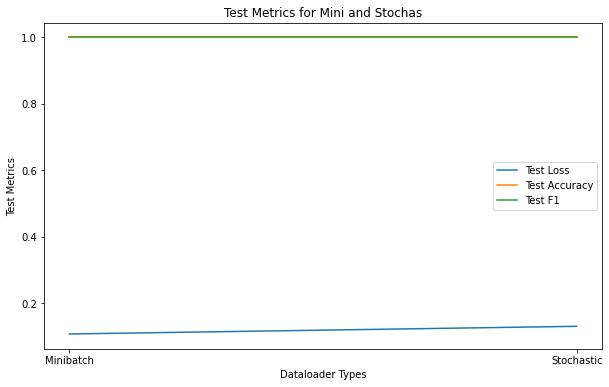

In [32]:
"""
Plotting Test Losses
"""
plt.figure(figsize=(10, 6))

data_names = ['Minibatch','Stochastic']

plt.plot(data_names, final_test_loss)
plt.plot(data_names, final_test_accuracy)
plt.plot(data_names, final_test_f1)
plt.title("Test Metrics for Mini and Stochas")
plt.xlabel("Dataloader Types")
plt.ylabel("Test Metrics")
plt.legend(['Test Loss', 'Test Accuracy', 'Test F1'])
plt.show()

In [33]:
data_names = ['Minibatch','Stochastic']
final_train_loss = [train_loss[-1] for train_loss in final_train_loss]
final_train_accuracy = [train_accuracy[-1] for train_accuracy in final_train_accuracy]
final_train_f1 = [train_f1[-1] for train_f1 in final_train_f1]

data = {
    'DataLoader Name': data_names,
    'Train Loss': final_train_loss,
    'Train Accuracy': final_train_accuracy,
    'Train F1 Score': final_train_f1
}

df = pd.DataFrame(data)
print(df)


  DataLoader Name  Train Loss  Train Accuracy  Train F1 Score
0       Minibatch    0.022206             1.0             1.0
1      Stochastic    0.031064             1.0             1.0


In [34]:
data_names = ['Minibatch','Stochastic']

test_metrics = {
    'DataLoader Name': data_names,
    'Test Loss': final_test_loss,
    'Test Accuracy': final_test_accuracy,
    'Test F1 Score': final_test_f1
}

test_metrics_df = pd.DataFrame(test_metrics)
test_metrics_df.set_index('DataLoader Name', inplace=True)
print(test_metrics_df)


                 Test Loss  Test Accuracy  Test F1 Score
DataLoader Name                                         
Minibatch         0.106991            1.0            1.0
Stochastic        0.130085            1.0            1.0


## Analysis:
Both `Minibatch` and `Stochastic` give extremely good scores `1.0` on the training and the testing data. Overall, the train loss and the test loss is lower for the `Minibatch` compared to the `Stochastic` Model.

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

# Overall Conclusions:

Adam is regarded to be superior to SGD without momentum and its straightforward variations. These are a few explanations for why Adam is frequently chosen:
1. Adam uses the estimated first and second moments of the gradients to adaptively alter the learning rate for each weight in the neural network. In contrast to standard SGD, where the learning rate is fixed for all weights, this allows the learning rate to be automatically modified for each weight.
2. Adam frequently converges more quickly than other optimisation techniques, particularly in large neural networks with complicated structures. This is so because Adam accelerates convergence by combining the benefits of RMSprop and SGD with momentum.

----

Both MultiplicativeLR and MultiStepLR, in general, are efficient techniques for modifying the learning rate during training. Whereas MultiStepLR makes adjustments to the learning rate at particular training milestones, MultiplicativeLR scales the learning rate by a constant factor at each epoch.

Yet, our schedulers do not appear to perform significantly differently, which could be because of: Characteristics of the dataset and the task, model architecture, and optimisation algorithm

-----

Minibatch gradient descent can outperform stochastic gradient descent for a number of reasons:
1. Faster convergence: Minibatch gradient descent can use a mini-batch of training data to perform matrix operations using vectorization, leading to quicker calculations and convergence.
2. Improved generalisation: Because minibatch gradient descent adjusts model parameters based on the average gradient of numerous examples rather than a single example, it can be less prone to overfitting than SGD.